# Predicticting Heart Disease in Patients

By: Grace Co

### Introduction

According to the Government of Canada, heart disease is the second leading cause of death in Canada, and about 1 in 12 (2.6 million) Canadian adults age 20 and over live with diagnosed heart disease. In fact, every hour, about 14 Canadian adults with diagnosed heart disease die.

Heart disease is evidently a very serious problem. As a result, in this project, I will focus on predicting heart disease using a dataset from the UCI Heart Disease dataset. According to the American Heart Association, heart failure can progress, which is why researchers have identified four stages of the disease. This dataset includes information on 303 patients, each with 14 attributes, including their heart disease classification (ranging from 0, indicating no heart disease, to 4, indicating very severe heart disease). The goal is to analyze these attributes and build a model to predict whether a future undiagnosed patient has some form of heart disease.

From the data, I have decided to use three variables: Thalach (maximum heart rate achieved), Serum Cholesterol, and ST Depression to analyze and use to predict heart disease in patients. So my question for this project is: **Can using Thalach, Serum Cholesterol, and ST Depression predict if a person has heart disease?**

**Penn Medicine - Heart Failure Classification:**

![Heart Disease](https://www.pennmedicine.org/-/media/images/miscellaneous/infographics/heart_failure_classifications_infographic_1.ashx?h=350&w=280&la=en)

### Methods & Results

In order to determine the diagnosis of heart disease in new patients, we will compare their Thalach, Serum Cholesterol, and ST Depression values to individuals with a known diagnosis. I will also filter the individuals in the dataset who have heart disease apart from those who do not have heart disease. To make the dataset easier to work with and easier to predict heart disease, I will group individuals with heart disease classifications from 1-4 into the same group of having heart disease.

The first step in performing our data analysis is to upload the necessary libraries and read the data into R. Then, to clean, wrangle, and filter the data to select the columns of interest: heart disease, Thalach, Serum Cholesterol, and ST Depression. Since I will be performing a classification, I will split the data into two sets, one for training (75%) and one for testing (25%). Tables are then made to display the total number of cases in our training set for those with heart disease and for those who do not have heart disease to verify that the number of cases for each category is somewhat equal. The last step of the preliminary data analysis is to visualize the training set as a scatter plot to view the relationship between the three variables in determining the presence of heart disease in individuals.

In order to find the optimal K value for the model, I need to create a new workflow to be used during cross-validation. The new workflow will determine the accuracy of the K values that it tests, and after plotting the accuracy, I will be able to pick a K value with the highest accuracy estimate. I can compute the three predictor variables (Thalach, Serum Cholesterol, and ST Depression) to classify an observation as having heart disease or not by using the optimal K-value for the k-nearest neighbor classification algorithm.

After that, I will use the found optimal K value to build a model specification, then use that final model to predict on the test dataset. Using the predictions, I can then print out the metrics of accuracy, precision, recall and create a confusion matrix to determine further insights. From these insights, I will be able to summarize my findings and discuss the potential applications of this report.

In [39]:
# Loading libraries
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(GGally)
library(yardstick)
options(repr.matrix.max.rows = 10)

In [40]:
# Loading in data

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

heart_data <- read_csv(url, col_names=FALSE, show_col_types = FALSE)

colnames(heart_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")

heart_data <- heart_data |>
                    mutate(ca = as_factor(ca), thal = as_factor(thal), num = as_factor(num))
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3


The data is now loaded, wrangled and cleaned and ready to be analyzed.

In [41]:
# Preliminary Exploratory Data Analysis: Training and Testing Data
set.seed(2020)
heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

The data is split into two: 75% for training and 25% for testing. This ensures that the data I use to test the model will not have been seen before and can accurately test the model's accuracy.

In [42]:
#Exploratory Data Analysis: Organize the training data into tables

heart_have_disease <- heart_train |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(num_alt = as_factor(hd))
heart_no_disease <- heart_train |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(num_alt = as_factor(hd))
heart_train <- rbind(heart_have_disease, heart_no_disease)

heart_have_disease_test <- heart_test |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(num_alt = as_factor(hd))
heart_no_disease_test <- heart_test |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(num_alt = as_factor(hd))
heart_test <- rbind(heart_have_disease_test, heart_no_disease_test)

heart_count_case<-group_by(heart_train, hd) |>
    summarize(number_of_cases=n())
heart_count_case

heart_indicator_mean<-group_by(heart_train, hd) |>
    summarize(across(age:slope, mean))
heart_indicator_mean

heart_train

hd,number_of_cases
<chr>,<int>
no,123
yes,103


hd,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,52.98374,0.5528455,2.739837,130.7561,244.0650,0.1544715,0.8373984,158.8537,0.1463415,0.5902439,1.406504
yes,56.91262,0.8543689,3.524272,134.8447,246.7864,0.1553398,1.1747573,138.7864,0.5922330,1.5407767,1.854369


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hd,num_alt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<chr>,<fct>
70,1,4,145,174,0,0,125,1,2.6,3,0.0,7.0,4,yes,yes
57,1,4,165,289,1,2,124,0,1.0,2,3.0,7.0,4,yes,yes
38,1,1,120,231,0,0,182,1,3.8,2,0.0,7.0,4,yes,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,yes,yes
48,1,2,110,229,0,0,168,0,1.0,3,0.0,7.0,1,yes,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,2,130,221,0,2,163,0,0.0,1,0.0,7.0,0,no,no
56,1,2,120,240,0,0,169,0,0.0,3,0.0,3.0,0,no,no
55,0,2,132,342,0,0,166,0,1.2,1,0.0,3.0,0,no,no


Here, I do a preliminary scan to ensure that the total number of cases that have heart disease is somewhat equal to the number of cases that do not have heart disease (103 and 123, respectively).

I then added an extra column, "have disease," which is shortened to "hd," that sorts the individuals with heart disease from the individuals without heart disease. I have grouped people with heart disease from 1-4 as having heart disease and those with 0 as having no heart disease.

With the additional column, I have created a summary of the dataset that is relevant for the exploratory data analysis.

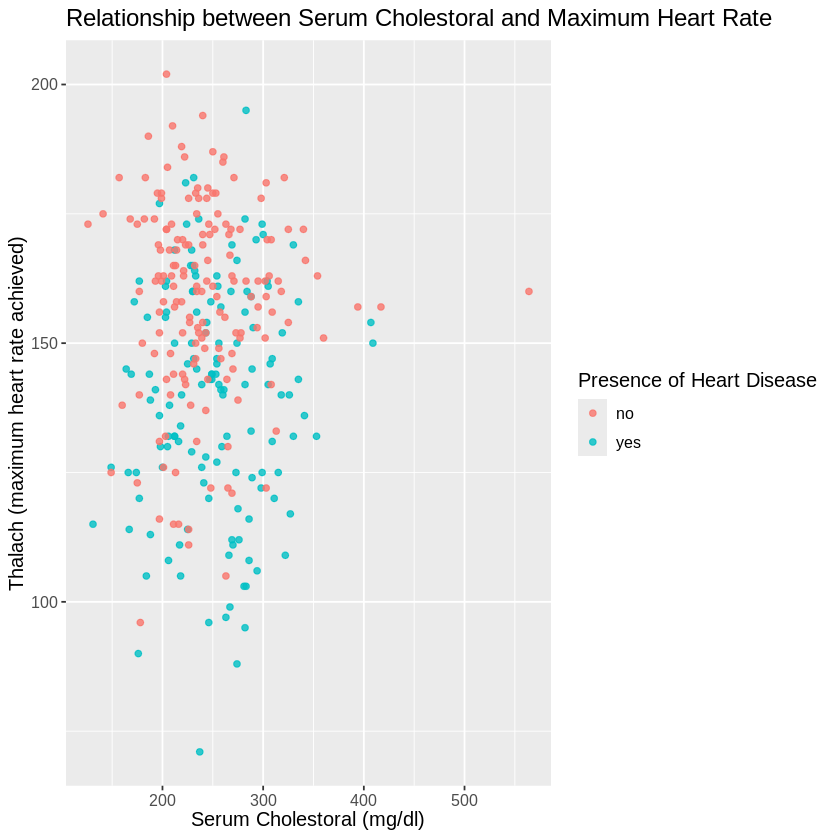

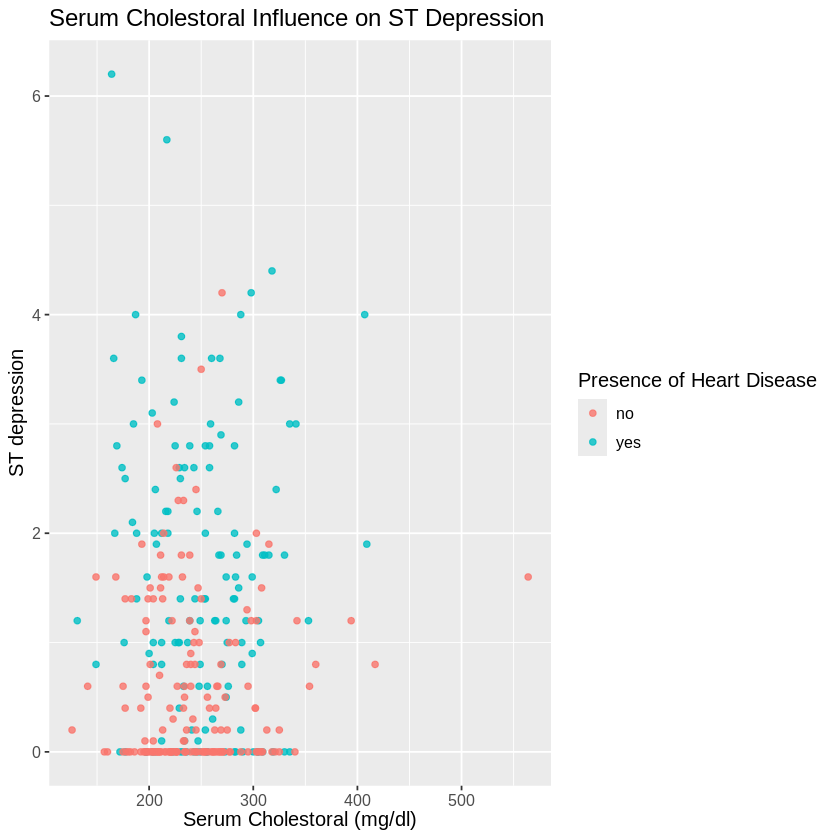

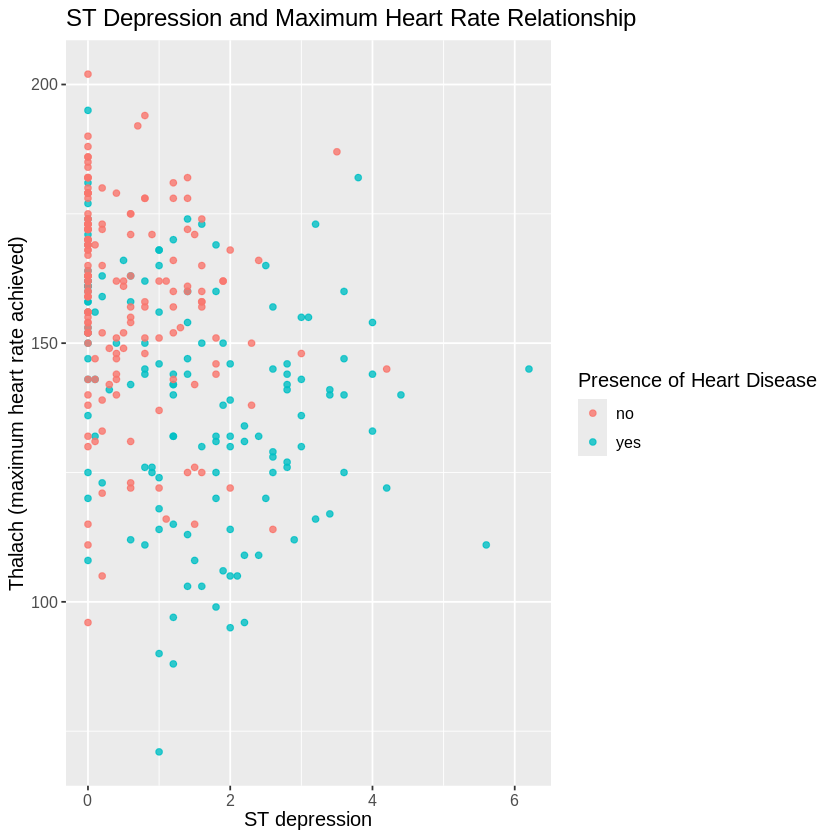

In [43]:
# Preliminary Exploratory Data Analysis: Visualize the training data
heart_have_disease <- heart_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(num_alt = as_factor(hd))
heart_no_disease <- heart_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(num_alt = as_factor(hd))
heart_data_alt <- rbind(heart_have_disease, heart_no_disease)

chol_vs_thalac <- heart_data_alt |>
                    ggplot(aes(x = chol, y = thalach, color = hd)) +
                    geom_point(alpha = .8) +
                    labs(x = "Serum Cholestoral (mg/dl)", y = "Thalach (maximum heart rate achieved)", color = "Presence of Heart Disease") +
                    ggtitle("Relationship between Serum Cholestoral and Maximum Heart Rate") +
                    theme(text = element_text(size = 12))
chol_vs_thalac

chol_vs_oldpeak <- heart_data_alt |>
                    ggplot(aes(x = chol, y = oldpeak, color = hd)) +
                    geom_point(alpha = .8) +
                    labs(x = "Serum Cholestoral (mg/dl)", y = "ST depression", color = "Presence of Heart Disease") +
                    ggtitle("Serum Cholestoral Influence on ST Depression") +
                    theme(text = element_text(size = 12))
chol_vs_oldpeak 

oldpeak_vs_thalac <- heart_data_alt |>
                    ggplot(aes(x = oldpeak, y = thalach, color = hd)) +
                    geom_point(alpha = .8) +
                    labs(x = "ST depression", y = "Thalach (maximum heart rate achieved)", color = "Presence of Heart Disease") +
                    ggtitle("ST Depression and Maximum Heart Rate Relationship") +
                    theme(text = element_text(size = 12))
oldpeak_vs_thalac


This is the visualization of the three variables I have chosen plotted on a scatter graph. I can easily identify some minor patterns within these three plots and visually see some correlations that can help train my model.

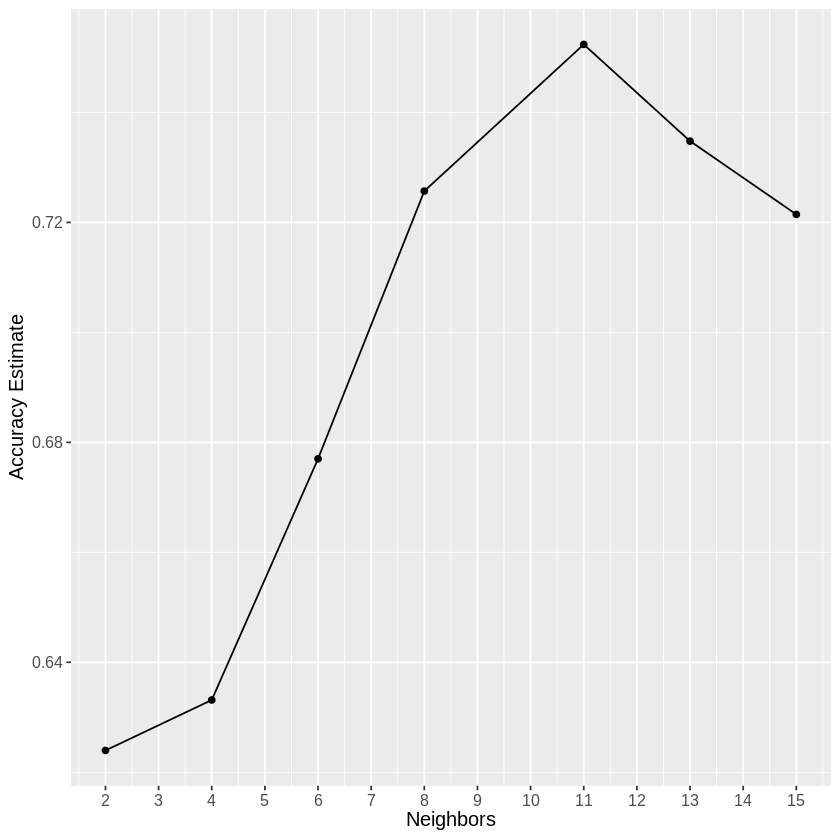

In [44]:
#choosing which k I should use
heart_recipe <- recipe(hd ~ thalach + oldpeak + chol, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 5)

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = heart_vfold, grid = 10) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  scale_x_continuous(breaks = 1:15) +
  theme(text = element_text(size=12))

cross_val_plot

To choose the optimal K value for this model, I have conducted a 5-fold cross-validation. From the graph above, it is clear that the K with the highest accuracy estimate is when K = 11. As a result, I will now be using K = 11 to build my model.

In [45]:
# build model specification with the best value for k

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
  set_engine("kknn") |>
  set_mode("classification")

mnist_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(mnist_spec) |>
  fit(data = heart_train)

mnist_fit 

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3097345
Best kernel: rectangular
Best k: 11

I have built my model using K = 11.

In [46]:
# Use my final model to predict on the test dataset and print results

heart_predictions <- predict(mnist_fit, heart_test) |>
    bind_cols(heart_test)  

heart_predictions <- heart_predictions |>
       mutate(hd = as.factor(hd))

accuracy <- heart_predictions |>
  accuracy(truth = hd, estimate = .pred_class)

precision <- heart_predictions |>
  precision(truth = hd, estimate = .pred_class)

recall <- heart_predictions |>
  recall(truth = hd, estimate = .pred_class)

heart_conf_mat <- heart_predictions |> 
       conf_mat(truth = hd, estimate = .pred_class)

accuracy
precision
recall
heart_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6883117


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6888889


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.7560976


          Truth
Prediction no yes
       no  31  14
       yes 10  22

Here, I have printed out the accuracy, precision, recall, and confusion matrix of how my model performed in terms of determining if an individual has heart disease.

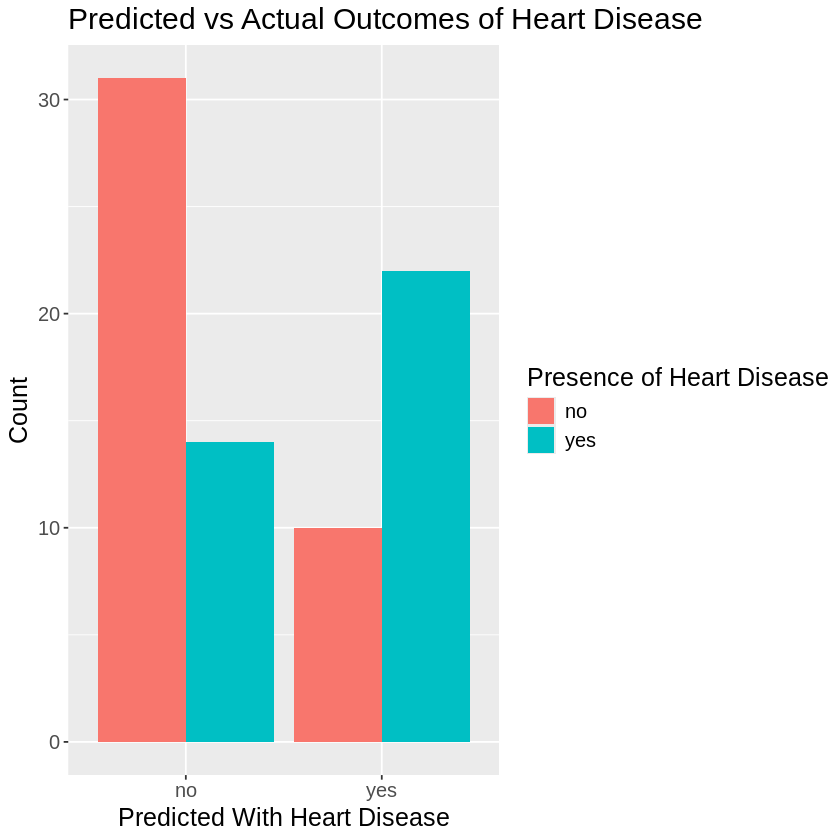

In [50]:
prediction_plot <- heart_predictions |>
  ggplot(aes(x = .pred_class, fill = hd)) +
  geom_bar(position = "dodge") +
  labs(x = "Predicted With Heart Disease", y = "Count", fill = "Presence of Heart Disease") +
  ggtitle("Predicted vs Actual Outcomes of Heart Disease") +
  theme(text = element_text(size = 15))

prediction_plot

To visualize the predicted outcomes of my model, I have also created a bar graph to show how well my model determined if an individual has heart disease. This bar graph helps visualize the data from the confusion matrix, allowing me to compare the correct predictions versus the incorrect predictions.

### Discussion

The question I was hoping to answer was: can I predict heart disease with three key variables: Thalach (maximum heart rate achieved), Serum Cholesterol, and ST Depression? Based on my classification model, I was able to obtain these metrics:

- Accuracy: 0.688
- Precision: 0.689
- Recall: 0.756

The confusion matrix also showed that out of 77 instances, 53 were correctly classified (31 with no heart disease and 22 with heart disease), and 24 were misclassified (14 with no heart disease incorrectly classified as having heart disease and 10 with heart disease incorrectly classified as not having heart disease).

According to Mayo Clinic, heart disease symptoms depend on the type of heart disease, and often people are not diagnosed until they experience a heart attack, angina, stroke, or heart failure. Knowing this, I was not expecting very high accuracy from my model, which only used 3 variables. Additionally, I grouped individuals with levels 1-4 of heart disease into a single category of having heart disease. I predicted that because of this grouping, individuals with heart disease may have a wider range of data points and symptoms, which could make it more difficult for my model to process.

I think that an accuracy of 68.8% is reasonable based on the factors above. I also noticed that the model's recall was higher than its precision. This means that the model is better at identifying true positive cases of heart disease than it is at correctly identifying true negative cases. I found that interesting because I thought that with the wide spread of heart disease levels 1-4, the model might have more difficulty identifying individuals with heart disease compared to those without.

In terms of significant implications, I believe that my model, with a recall of 0.756, is relatively good at identifying patients with heart disease, which is crucial for early diagnosis and treatment. However, this number still falls short of being precise enough because by using just this model could result in diagnosing a fair number of false positives (people diagnosed with heart disease who do not actually have it), potentially leading to unnecessary anxiety and testing for some patients.

It is also important to note that heart disease is dependent on numerous variables, and although my model can indicate the presence of heart disease, it is far from confirming a diagnosis. This model will require further testing and research, but it serves as a good starting point when information is limited. With additional training and research, I believe this model could become a powerful and useful tool in the field of medicine, potentially aiding in early diagnosis.

Some future research questions this report could lead to include using additional variables and incorporating more features from the dataset such as age, sex, and cp (chest pain). Another question could be how other potentially more advanced models could use this dataset to create a more precise model. I am also interested in exploring datasets from different demographic groups to determine if the results hold across various populations or if certain demographics exhibit higher accuracy in determining heart disease with this model. Additionally, integrating scientific insights into the role of each variable in heart disease could provide deeper understanding and improve the model's effectiveness.

### References

  Classes and stages of heart failure. (2017, May 8). Www.Heart.Org. https://www.heart.org/en/health-topics/heart-failure/what-is-heart-failure/classes-of-heart-failure

  Heart disease - Symptoms and causes. (2022, August 25). Mayo Clinic. https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118

  Heart disease in Canada. (n.d.). Canada.Ca. Retrieved June 20, 2024, from https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html

  UCI machine learning repository. (n.d.). Retrieved June 20, 2024, from https://archive.ics.uci.edu/dataset/45/heart+disease

  (N.d.). Retrieved June 20, 2024, from https://www.pennmedicine.org/updates/blogs/heart-and-vascular-blog/2022/july/heart-failure-classification--stages-of-heart-failure-and-their-treatments
